### Importing Libraries

In [1]:
%%capture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import hashlib
import pickle
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score,GridSearchCV

# importing classification metrics 
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,recall_score,precision_score,roc_curve,auc,roc_auc_score

### Loading the data

In [2]:
normal1 = pd.read_csv('Normal_PE_Khaled_HP_Nov22.csv')
normal2 = pd.read_csv('Normal_PE_VMH_Dec22.csv')
normal3 = pd.read_csv('PE_Normal_Khaled_Dell_Dec22.csv')
normal4 = pd.read_csv('normal_data1.csv')
normal5 = pd.read_csv('normal_data2.csv')
###################################################################################
malware1 = pd.read_csv('malware_data_1.csv')
malware2 = pd.read_csv('malware_data_2.csv')
malware3 = pd.read_csv('malware_data_3.csv')
malware4 = pd.read_csv('malware_data_Dec_22.csv')

In [3]:
# ensuring that the label of malware is 1 and normal is 0
# appending the normal files in the same table
normal = normal1.append(normal2,ignore_index = True).append(normal3,ignore_index = True).append(normal4,ignore_index = True).append(normal5,ignore_index = True)
normal['Class'] = 0
# normal = normal.iloc[:46000,:]
# appending the malware files in the same table
malware = malware1.append(malware2,ignore_index = True).append(malware3,ignore_index = True).append(malware4,ignore_index = True)
malware['Class'] = 1
# malware = malware.iloc[:40000,:]
# appending all the data in the same table
data = normal.append(malware,ignore_index = True)

In [4]:
# checking the shape of the data
print("Shape of the Data: ",data.shape)

Shape of the Data:  (486662, 80)


## Preprocessing Data

In [5]:
# checking dulicates
print("Number of duplicated raws: ",data.duplicated().sum())
# dropping duplicated raws
data = data.drop_duplicates(keep='first')
# checking the shape of the data
print("Shape of the Data: ",data.shape)

Number of duplicated raws:  191560
Shape of the Data:  (295102, 80)


In [6]:
# removing the rows with same hash of the files we will test on after generating the model
def get_md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

In [7]:
# removing malware samples in the data having the same hash of the test normal files
indices = []
for root, dirs, files in os.walk(r"C:\Users\user\Downloads\malwares\normal"):
    for ffile in files:
        hash_ = get_md5(os.path.join(root, ffile))
        if hash_ in data['md5'].tolist():
            indices.append(data.index[data['md5']==hash_].tolist()[0])
            
data.drop(indices,inplace = True)
print("Shape of the Data: ",data.shape)

Shape of the Data:  (294634, 80)


In [ ]:
# removing normal samples in the data having the same hash of the test normal files
indices = []
for root, dirs, files in os.walk(r"C:\Users\user\Downloads\malwares\ers"):
    for ffile in files:
        hash_ = get_md5(os.path.join(root, ffile))
        if hash_ in data['md5'].tolist():
            indices.append(data.index[data['md5']==hash_].tolist()[0])
            
data.drop(indices,inplace = True)
print("Shape of the Data: ",data.shape)

### Shuffling the data

In [8]:
# shuffling the data
data = data.sample(frac=1,random_state=1)

In [9]:
data['Class'].value_counts()

1    179071
0    115563
Name: Class, dtype: int64

### Selecting the Important features

In [10]:
selected_features = [
        "Machine",
        "SizeOfOptionalHeader",
        "Characteristics",
        "MajorLinkerVersion",
        "MinorLinkerVersion",
        "SizeOfCode",
        "SizeOfInitializedData",
        "SizeOfUninitializedData",
        "AddressOfEntryPoint",
        "BaseOfCode",
        "BaseOfData",
        "ImageBase",
        "SectionAlignment",
        "FileAlignment",
        "MajorOperatingSystemVersion",
        "MinorOperatingSystemVersion",
        "MajorImageVersion",
        "MinorImageVersion",
        "MajorSubsystemVersion",
        "MinorSubsystemVersion",
        "SizeOfImage",
        "SizeOfHeaders",
        "CheckSum",
        "Subsystem",
        "DllCharacteristics",
        "SizeOfStackReserve",
        "SizeOfStackCommit",
        "SizeOfHeapReserve",
        "SizeOfHeapCommit",
        "LoaderFlags",
        "NumberOfRvaAndSizes",
        "SectionLength",
        "SectionsMeanEntropy",
        "SectionsMinEntropy",
        "SectionsMaxEntropy",
        "SectionsMeanRawsize",
        "SectionsMinRawsize",
        "SectionMaxRawsize",
        "SectionsMeanVirtualsize",
        "SectionsMinVirtualsize",
        "SectionMaxVirtualsize",
        "DirectoryEntryImport",
        "DirectoryEntryImportSize",
        "ImportsNbOrdinal",
        "DirectoryEntryExportSize",
        "ResourcesNb",
        "ResourcesMeanEntropy",
        "ResourcesMinEntropy",
        "ResourcesMaxEntropy",
        "ResourcesMeanSize",
        "ResourcesMinSize",
        "ResourcesMaxSize",
        "LoadConfigurationSize",
        "VersionInformationSize",
        "Class"
]
data = data[selected_features]

In [11]:
data.shape

(294634, 55)

In [12]:
# ensuring that all features are numeric values and removing rows with null values
for column in selected_features:
    data[column] = pd.to_numeric(data[column], errors = 'coerce')
    data.dropna(inplace = True)

### Splitting the data into X and Y

In [13]:
X = data.drop(columns = ['Class']).values
# X = data.drop(columns = ['md5','Name','Machine','Class']).values
y = data['Class'].values

print("Shape of features: ",X.shape)
print("Shape of label: ",y.shape)

Shape of features:  (294633, 54)
Shape of label:  (294633,)


In [14]:
data['Class'].value_counts(normalize = True)*100

1    60.777645
0    39.222355
Name: Class, dtype: float64

In [15]:
data['Class'].value_counts()

1    179071
0    115562
Name: Class, dtype: int64

### Splitting the data into Training (70%) and Testing (30%)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=0,stratify=y)

print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (206243, 54)
y_train shape:  (206243,)
X_test shape:  (88390, 54)
y_test shape:  (88390,)


In [17]:
# defining the function to draw the ROC Curve
def plot_roc_curve(roc_auc_train, roc_auc_test):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_tr, tpr_tr, 'g', label = 'Training AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_ts, tpr_ts, 'b', label = 'Testing AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# defining function for plotting Confusion Matrix
def plot_conf_matrix (conf_matrix, dtype):
    class_names = [0,1]
    fontsize=14
    df_conf_matrix = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
    fig = plt.figure()
    heatmap = sns.heatmap(df_conf_matrix, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for {0}'.format(dtype))

# Voting Classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
# defining the model
# Initialize the individual classifiers
bdt = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)
rfc = RandomForestClassifier(random_state=42)
etc = ExtraTreesClassifier(random_state=42)
abc = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

# Create the voting classifier
voting_classifier = VotingClassifier(estimators=[
    ('bdt', bdt),
    ('rfc', rfc),
    ('etc', etc),
    ('abc', abc),
    ('gbc', gbc)
], voting='soft')

In [19]:
%%time
# Train the voting classifier
voting_classifier.fit(X_train, y_train)

Wall time: 5min 46s


VotingClassifier(estimators=[('bdt',
                              BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                                random_state=42)),
                             ('rfc', RandomForestClassifier(random_state=42)),
                             ('etc', ExtraTreesClassifier(random_state=42)),
                             ('abc', AdaBoostClassifier(random_state=42)),
                             ('gbc',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [20]:
# making prediction and computing metrics on training data
train_predict = voting_classifier.predict(X_train)
print("Training Results: ")
print("Train Accuracy: ",accuracy_score(y_train,train_predict))
print("Train Precision: ",precision_score(y_train,train_predict))
print("Train Recall: ",recall_score(y_train,train_predict))
print("Train F1 Score: ",f1_score(y_train,train_predict))
print("---------------------------------------------")

Training Results: 
Train Accuracy:  0.9997333242825212
Train Precision:  0.999585323646919
Train Recall:  0.9999760670123654
Train F1 Score:  0.999780657151175
---------------------------------------------


In [21]:
%%time
# making prediction and computing metrics on testing data
test_predict = voting_classifier.predict(X_test)
print("Testing Results: ")
print("Test Accuracy: ",accuracy_score(y_test,test_predict))
print("Test Precision: ",precision_score(y_test,test_predict))
print("Test Recall: ",recall_score(y_test,test_predict))
print("Test F1 Score: ",f1_score(y_test,test_predict))

Testing Results: 
Test Accuracy:  0.9868876569747709
Test Precision:  0.9849071921473117
Test Recall:  0.9936523891960314
Test F1 Score:  0.9892604638664184
Wall time: 4.76 s


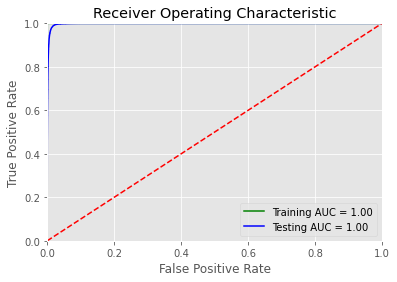

In [22]:
# Computing prediction with its probability for drawing ROC Curve 
y_pred_train_prob = voting_classifier.predict_proba(X_train)[:,1]
y_pred_test_prob = voting_classifier.predict_proba(X_test)[:,1]

# ROC for training data
fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr, tpr_tr)
# ROC for testing data
fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_ts, tpr_ts)

# plotting
plot_roc_curve(roc_auc_train, roc_auc_test)

# saving the model
with open('voting_model_54.pkl', 'wb') as f:
    pickle.dump(voting_classifier, f)

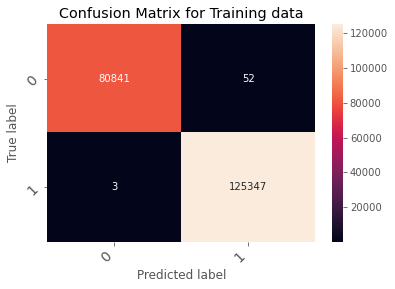

In [23]:
plot_conf_matrix(confusion_matrix(y_train, train_predict), "Training data")

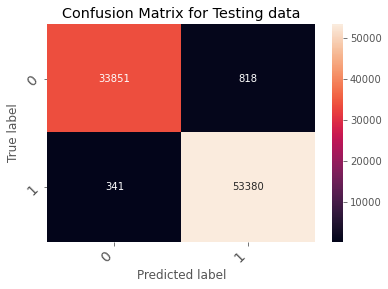

In [24]:
plot_conf_matrix(confusion_matrix(y_test, test_predict), "Testing data")

### True Positive Rate & False Positive Rate

In [25]:
CM = confusion_matrix(y_train, train_predict)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
print("Train TPR: ",TPR)
print("Train FPR: ",FPR)

Train TPR:  0.9999760670123654
Train FPR:  0.0006428244718331623


In [26]:
CM = confusion_matrix(y_test, test_predict)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
print("Test TPR: ",TPR)
print("Test FPR: ",FPR)

Test TPR:  0.9936523891960314
Test FPR:  0.023594565750382185


# Random Forest

Training Results: 
Train Accuracy:  0.9999465811965812
Train Precision:  0.9999285739795007
Train Recall:  0.9999642857142857
Train F1 Score:  0.9999464295280442
---------------------------------------------
Testing Results: 
Test Accuracy:  0.9722880053180439
Test Precision:  0.9686543710197668
Test Recall:  0.976
Test F1 Score:  0.9723133120252376


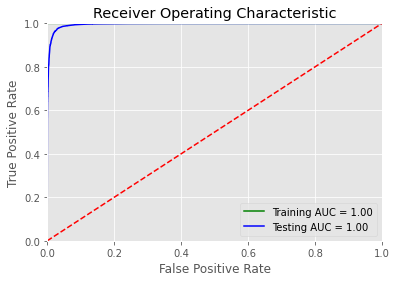

In [29]:
from sklearn.ensemble import RandomForestClassifier
# defining the model
rf = RandomForestClassifier(n_estimators = 140,max_depth = 30, class_weight = 'balanced',random_state=0)
# training the model
rf.fit(X_train, y_train)
##############################################
# making prediction and computing metrics on training data
train_predict = rf.predict(X_train)
print("Training Results: ")
print("Train Accuracy: ",accuracy_score(y_train,train_predict))
print("Train Precision: ",precision_score(y_train,train_predict))
print("Train Recall: ",recall_score(y_train,train_predict))
print("Train F1 Score: ",f1_score(y_train,train_predict))
print("---------------------------------------------")
# making prediction and computing metrics on testing data
test_predict = rf.predict(X_test)
print("Testing Results: ")
print("Test Accuracy: ",accuracy_score(y_test,test_predict))
print("Test Precision: ",precision_score(y_test,test_predict))
print("Test Recall: ",recall_score(y_test,test_predict))
print("Test F1 Score: ",f1_score(y_test,test_predict))
##################################################
# Computing prediction with its probability for drawing ROC Curve 
y_pred_train_prob = rf.predict_proba(X_train)[:,1]
y_pred_test_prob = rf.predict_proba(X_test)[:,1]

# ROC for training data
fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr, tpr_tr)
# ROC for testing data
fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_ts, tpr_ts)

# plotting
plot_roc_curve(roc_auc_train, roc_auc_test)

# saving the model
with open('rf_model_54.pkl', 'wb') as f:
    pickle.dump(rf, f)

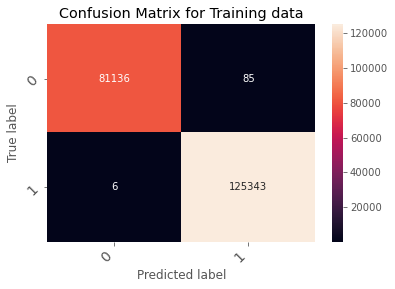

In [31]:
plot_conf_matrix(confusion_matrix(y_train, train_predict), "Training data")

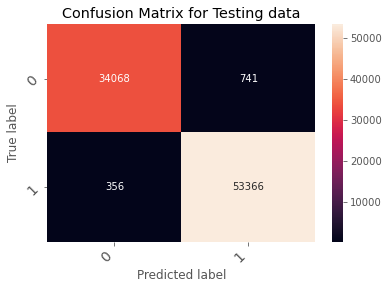

In [32]:
plot_conf_matrix(confusion_matrix(y_test, test_predict), "Testing data")

### True Positive Rate & False Positive Rate

In [18]:
CM = confusion_matrix(y_train, train_predict)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
print("Train TPR: ",TPR)
print("Train FPR: ",FPR)

Train TPR:  0.9998482379628743
Train FPR:  0.0011875015462259717


In [19]:
CM = confusion_matrix(y_test, test_predict)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
print("Test TPR: ",TPR)
print("Test FPR: ",FPR)

Test TPR:  0.9898613388996571
Test FPR:  0.02453314861315554


# Decision Tree

Training Results: 

Train Accuracy:  0.9999466117900582
Train Precision:  0.9999920119501227
Train Recall:  0.999920125243618
Train F1 Score:  0.999956067304889
--------------------------------------------------------
Testing Results: 

Test Accuracy:  0.9749838623829314
Test Precision:  0.9834426506793963
Test Recall:  0.9752497390785746
Test F1 Score:  0.9793290600290085


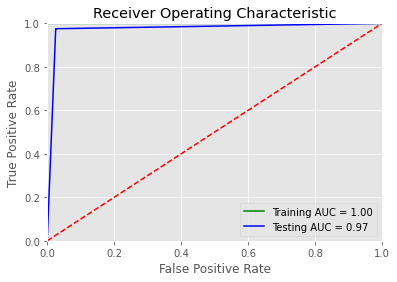

In [20]:
from sklearn.tree import DecisionTreeClassifier
# defining the model
dt = DecisionTreeClassifier()
# training the model
dt.fit(X_train, y_train)
##############################################
# making prediction and computing metrics on training data
train_predict = dt.predict(X_train)
print("Training Results: \n")
print("Train Accuracy: ",accuracy_score(y_train,train_predict))
print("Train Precision: ",precision_score(y_train,train_predict))
print("Train Recall: ",recall_score(y_train,train_predict))
print("Train F1 Score: ",f1_score(y_train,train_predict))
print("--------------------------------------------------------")
# making prediction and computing metrics on testing data
test_predict = dt.predict(X_test)
print("Testing Results: \n")
print("Test Accuracy: ",accuracy_score(y_test,test_predict))
print("Test Precision: ",precision_score(y_test,test_predict))
print("Test Recall: ",recall_score(y_test,test_predict))
print("Test F1 Score: ",f1_score(y_test,test_predict))
##################################################
# Computing prediction with its probability for drawing ROC Curve 
y_pred_train_prob = dt.predict_proba(X_train)[:,1]
y_pred_test_prob = dt.predict_proba(X_test)[:,1]

# ROC for training data
fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr, tpr_tr)

# ROC for testing data
fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_ts, tpr_ts)

#plotting
plot_roc_curve(roc_auc_train, roc_auc_test)

# saving the model
with open('dt_model_15.pkl', 'wb') as f:
    pickle.dump(dt, f)

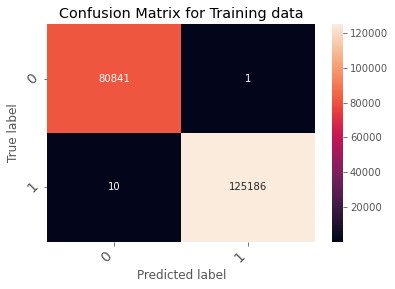

In [21]:
plot_conf_matrix(confusion_matrix(y_train, train_predict), "Training data")

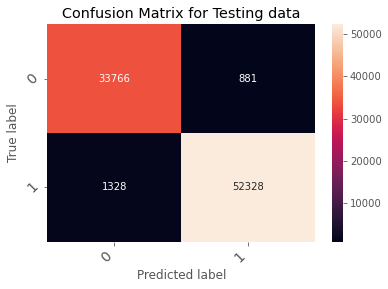

In [22]:
plot_conf_matrix(confusion_matrix(y_test, test_predict), "Testing data")

### True Positive Rate & False Positive Rate

In [23]:
CM = confusion_matrix(y_train, train_predict)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
print("Train TPR: ",TPR)
print("Train FPR: ",FPR)

Train TPR:  0.999920125243618
Train FPR:  1.2369807773187204e-05


In [24]:
CM = confusion_matrix(y_test, test_predict)
TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
print("Test TPR: ",TPR)
print("Test FPR: ",FPR)

Test TPR:  0.9752497390785746
Test FPR:  0.025427886974341212


# Bagging Decision Tree

Training Results: 

Train Accuracy:  0.9998547707798809
Train Precision:  0.999800588662269
Train Recall:  0.9999601113690576
Train F1 Score:  0.9998803436530286
--------------------------------------------------------
Testing Results: 

Test Accuracy:  0.9868746540759734
Test Precision:  0.9865044985004998
Test Recall:  0.9919399873422434
Test F1 Score:  0.989214776313347


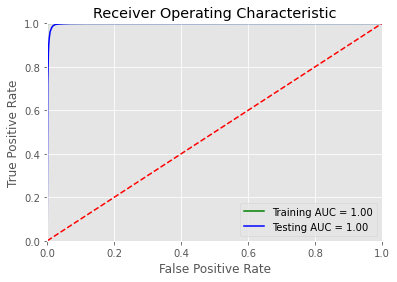

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
# defining the model
# Create a Decision Tree Classifier as the base estimator
base_estimator = DecisionTreeClassifier()
# Create a Bagging Classifier with 100 base estimators
bagging_classifier = BaggingClassifier(base_estimator=base_estimator, n_estimators=100)
# Fit the model on the training data
bagging_classifier.fit(X_train, y_train)
##############################################
# making prediction and computing metrics on training data
train_predict = bagging_classifier.predict(X_train)
print("Training Results: \n")
print("Train Accuracy: ",accuracy_score(y_train,train_predict))
print("Train Precision: ",precision_score(y_train,train_predict))
print("Train Recall: ",recall_score(y_train,train_predict))
print("Train F1 Score: ",f1_score(y_train,train_predict))
print("--------------------------------------------------------")
# making prediction and computing metrics on testing data
test_predict = bagging_classifier.predict(X_test)
print("Testing Results: \n")
print("Test Accuracy: ",accuracy_score(y_test,test_predict))
print("Test Precision: ",precision_score(y_test,test_predict))
print("Test Recall: ",recall_score(y_test,test_predict))
print("Test F1 Score: ",f1_score(y_test,test_predict))
##################################################
# Computing prediction with its probability for drawing ROC Curve 
y_pred_train_prob = bagging_classifier.predict_proba(X_train)[:,1]
y_pred_test_prob = bagging_classifier.predict_proba(X_test)[:,1]

# ROC for training data
fpr_tr, tpr_tr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr, tpr_tr)

# ROC for testing data
fpr_ts, tpr_ts, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_ts, tpr_ts)

#plotting
plot_roc_curve(roc_auc_train, roc_auc_test)

# saving the model
with open('bagging_dt_model_15.pkl', 'wb') as f:
    pickle.dump(bagging_classifier, f)

# Combining Graphs

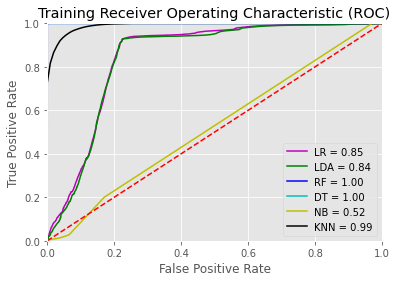

In [29]:
# training curves
y_pred_train_prob = lr.predict_proba(X_train)[:,1]
fpr_tr_lr, tpr_tr_lr, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_lr, tpr_tr_lr)
plt.plot(fpr_tr_lr, tpr_tr_lr, 'm', label = 'LR = %0.2f' % roc_auc_train)
#####################################################################
y_pred_train_prob = lda.predict_proba(X_train)[:,1]
fpr_tr_lda, tpr_tr_lda, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_lda, tpr_tr_lda)
plt.plot(fpr_tr_lda, tpr_tr_lda, 'g', label = 'LDA = %0.2f' % roc_auc_train)
########################################################################
y_pred_train_prob = rf.predict_proba(X_train)[:,1]
fpr_tr_rf, tpr_tr_rf, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_rf, tpr_tr_rf)
plt.plot(fpr_tr_rf, tpr_tr_rf, 'b', label = 'RF = %0.2f' % roc_auc_train)
######################################################################
y_pred_train_prob = dt.predict_proba(X_train)[:,1]
fpr_tr_dt, tpr_tr_dt, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_dt, tpr_tr_dt)
plt.plot(fpr_tr_dt, tpr_tr_dt, 'c', label = 'DT = %0.2f' % roc_auc_train)
######################################################################
y_pred_train_prob = nb.predict_proba(X_train)[:,1]
fpr_tr_nb, tpr_tr_nb, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_nb, tpr_tr_nb)
plt.plot(fpr_tr_nb, tpr_tr_nb, 'y', label = 'NB = %0.2f' % roc_auc_train)
###########################################################################
y_pred_train_prob = knn.predict_proba(X_train)[:,1]
fpr_tr_knn, tpr_tr_knn, threshold = roc_curve(y_train, y_pred_train_prob)
roc_auc_train = auc(fpr_tr_knn, tpr_tr_knn)
plt.plot(fpr_tr_knn, tpr_tr_knn, 'k', label = 'KNN = %0.2f' % roc_auc_train)
###########################################################################
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Training Receiver Operating Characteristic (ROC)')
plt.show()

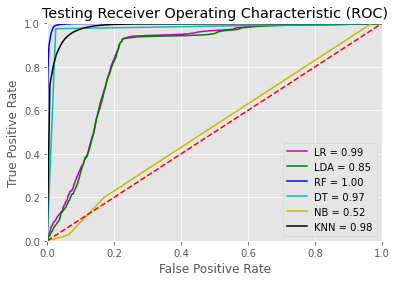

In [30]:
# testing roc curves
y_pred_test_prob = lr.predict_proba(X_test)[:,1]
fpr_tr_lr, tpr_tr_lr, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_lr, tpr_tr_lr)
plt.plot(fpr_tr_lr, tpr_tr_lr, 'm', label = 'LR = %0.2f' % roc_auc_train)
#####################################################################
y_pred_test_prob = lda.predict_proba(X_test)[:,1]
fpr_tr_lda, tpr_tr_lda, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_lda, tpr_tr_lda)
plt.plot(fpr_tr_lda, tpr_tr_lda, 'g', label = 'LDA = %0.2f' % roc_auc_test)
########################################################################
y_pred_test_prob = rf.predict_proba(X_test)[:,1]
fpr_tr_rf, tpr_tr_rf, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_rf, tpr_tr_rf)
plt.plot(fpr_tr_rf, tpr_tr_rf, 'b', label = 'RF = %0.2f' % roc_auc_test)
######################################################################
y_pred_test_prob = dt.predict_proba(X_test)[:,1]
fpr_tr_dt, tpr_tr_dt, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_dt, tpr_tr_dt)
plt.plot(fpr_tr_dt, tpr_tr_dt, 'c', label = 'DT = %0.2f' % roc_auc_test)
######################################################################
y_pred_test_prob = nb.predict_proba(X_test)[:,1]
fpr_tr_nb, tpr_tr_nb, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_nb, tpr_tr_nb)
plt.plot(fpr_tr_nb, tpr_tr_nb, 'y', label = 'NB = %0.2f' % roc_auc_test)
###########################################################################
y_pred_test_prob = knn.predict_proba(X_test)[:,1]
fpr_tr_knn, tpr_tr_knn, threshold = roc_curve(y_test, y_pred_test_prob)
roc_auc_test = auc(fpr_tr_knn, tpr_tr_knn)
plt.plot(fpr_tr_knn, tpr_tr_knn, 'k', label = 'KNN = %0.2f' % roc_auc_test)
###########################################################################
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Testing Receiver Operating Characteristic (ROC)')
plt.show()